In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
from scipy.spatial import cKDTree
from scipy.optimize import minimize
import PredictImage as prim
import os

In [2]:
cur_cam_index = 4
K = np.array([
    [3253.45225, -3.08866451, 4745.21992],
    [0.0, 3252.26117, 3142.22723],
    [0.0, 0.0, 1.0]
], dtype=np.float64)

#D = np.array([0.05003216, -0.04567757, 0.06960187, -0.03096402], dtype=np.float64)
D =np.array([  0.08330459003495257, 0.008459725805467274,  0.000681253494528032, 0.0001603712146519313])

image_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c5_img20250512-12_06_55CEST.jpg"

delta_pitch_deg=0.0
delta_yaw_deg=-3.0 
delta_roll_deg=-3.0 
delta_r=0.000

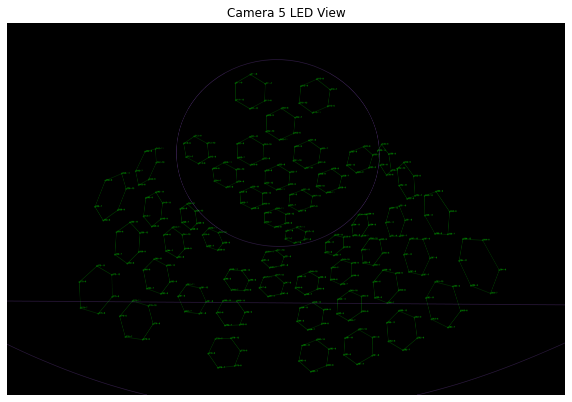

Saved image to camera5_f3253_p0_y-3_r-3_dr0.png


In [3]:
excluded_pmts = { 9, 12, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 30, 32, 35, 37, 38, 39, 40, 41, 45, 53, 54, 55, 56, 57, 63, 69, 
                 70, 71, 72, 73, 74, 77, 79}
#for delta_pitch_deg in [-5, 0, 5]:
#    for delta_yaw_deg in [-3, 0, 3]:
#        for delta_roll_deg in [-3, 0, 3]:
prim.simulate_fisheye_view("wcte_geometry_file.json", camera_index=cur_cam_index, K=K, D=D, delta_pitch_deg=delta_pitch_deg, delta_yaw_deg=delta_yaw_deg, delta_roll_deg=delta_roll_deg, delta_r=delta_r, excluded_pmts=excluded_pmts)

In [4]:

blobs = prim.run_blob_detector( image_filename_current, minarea=20, maxarea=1000, minthres=20, maxthres=255 )
print('number of blobs before filter:',len(blobs))
blobs_filtered = prim.filter_blobs_by_distance(blobs, 50)
print('number of blobs:',len(blobs_filtered))

number of blobs before filter: 305
number of blobs: 297


In [5]:
prim.draw_image_with_blobs_save( image_filename_current, blobs_filtered, 'c'+str(cur_cam_index+1)+'_with_blob_annotation.jpg' )

Annotated image saved to: c5_with_blob_annotation.jpg


In [6]:
# Initial guess: [pitch, yaw, roll, r, k1, k2, k3, k4]
initial_guess = [delta_pitch_deg, delta_yaw_deg, delta_roll_deg, delta_r, 
                 D[0], D[1], D[2], D[3] ]

matches, fitpars = prim.match_blobs(blobs_filtered, "wcte_geometry_file.json", 
                            cur_cam_index, K, D, initial_guess=initial_guess, 
                            bounds = [
                                        (-3, 3),   # delta_pitch_deg
                                        (-3.5, -2.5),   # delta_yaw_deg
                                        (-3.5, -2.5),   # delta_roll_deg
                                        (-0.01, 0.01), # delta_r in meters
                                        (0.082, 0.086), # k1 [ 0.05003216 -0.04567757  0.06960187 -0.03096402]
                                        (0.007, 0.009), # k2
                                        (0.0005, 0.0008), # k3
                                        (0.0001, 0.0002)   ])

In [7]:
fitpars

{'delta_pitch_deg': 0.559959971901251,
 'delta_yaw_deg': -2.7646138546480223,
 'delta_roll_deg': -2.9309085168495206,
 'delta_r': 0.009948130213575957,
 'D_fit': array([0.08591189, 0.00782023, 0.0007624 , 0.00013823]),
 'chi2': array(269000.),
 'success': True}

In [8]:
len(matches)

217

In [9]:
matches

[('000-6', 4740.4805, 2683.3267),
 ('000-7', 4905.209, 2494.184),
 ('000-10', 4417.2803, 2659.402),
 ('000-11', 4541.9736, 2877.2996),
 ('001-8', 5197.8965, 1867.6383),
 ('001-9', 4921.7856, 2077.4375),
 ('001-10', 4831.5713, 2233.5835),
 ('001-11', 5090.5195, 2469.217),
 ('002-6', 4856.074, 1763.2537),
 ('002-8', 4581.894, 1300.3597),
 ('002-9', 4551.6475, 1512.6208),
 ('002-10', 4446.5625, 1733.4973),
 ('003-6', 4007.9868, 1967.5132),
 ('003-7', 3867.0454, 2269.3882),
 ('003-8', 4078.723, 2431.2117),
 ('003-11', 4237.5107, 1817.7306),
 ('004-7', 3596.9937, 2707.1794),
 ('004-8', 3759.1477, 2681.5867),
 ('004-9', 3909.0952, 2723.2622),
 ('004-10', 3931.4019, 2380.0044),
 ('004-11', 3640.4443, 2234.7622),
 ('005-10', 4389.6763, 2794.7783),
 ('006-7', 4267.601, 3327.032),
 ('006-8', 4643.047, 3433.7825),
 ('006-10', 4666.315, 3251.3047),
 ('007-6', 4916.8833, 2886.725),
 ('007-7', 4720.1943, 3108.7708),
 ('007-8', 5080.2944, 3138.2493),
 ('007-10', 5086.3804, 2978.8308),
 ('009-6', 5798

In [10]:
img = prim.visualize_all_leds_and_matches( 
    image_filename_current,
    blobs,
    matches,
    fitpars,
    "wcte_geometry_file.json",
    cur_cam_index,
    K,
    fitpars['D_fit'],
    output_filename='c'+str(cur_cam_index+1)+"_blob_match_overlay.png",
    excluded_pmts=excluded_pmts
)


{'delta_pitch_deg': 0.559959971901251, 'delta_yaw_deg': -2.7646138546480223, 'delta_roll_deg': -2.9309085168495206, 'delta_r': 0.009948130213575957, 'D_fit': array([0.08591189, 0.00782023, 0.0007624 , 0.00013823]), 'chi2': array(269000.), 'success': True}
Overlay image saved to: c5_blob_match_overlay.png


In [11]:
output_filename = os.path.splitext( os.path.basename(image_filename_current) )[0] + ".json"

prim.save_matching_results_to_json(
    output_filename=output_filename,
    image_filename=image_filename_current,
    fitpars=fitpars, 
    matches=matches, 
    blobs=blobs, 
    geo_file="wcte_geometry_file.json", 
    camera_index=cur_cam_index, 
    K=K, 
    D=fitpars['D_fit'], 
    excluded_pmts=excluded_pmts)

excluded_pmts= {9, 12, 14, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 30, 32, 35, 37, 38, 39, 40, 41, 45, 53, 54, 55, 56, 57, 63, 69, 70, 71, 72, 73, 74, 77, 79}
geo_file= wcte_geometry_file.json
Sample matches labels: [('000-6', 4740.4805, 2683.3267), ('000-7', 4905.209, 2494.184), ('000-10', 4417.2803, 2659.402), ('000-11', 4541.9736, 2877.2996), ('001-8', 5197.8965, 1867.6383), ('001-9', 4921.7856, 2077.4375), ('001-10', 4831.5713, 2233.5835), ('001-11', 5090.5195, 2469.217), ('002-6', 4856.074, 1763.2537), ('002-8', 4581.894, 1300.3597)]
Sample label_to_sim keys: ['000-6', '000-7', '000-8', '000-9', '000-10', '000-11', '001-6', '001-7', '001-8', '001-9']
Saved results to c5_img20250512-12_06_55CEST.json
